In [25]:
from pathlib import Path
import torch
import torchvision
from torchvision import datasets, transforms
import time
from sklearn import metrics
import os
import time
import copy

In [26]:

git_dir = Path().parent.absolute().parent


train_dir = os.path.join(git_dir, "data/train")
test_dir = os.path.join(git_dir, "data/test")


train_transforms = transforms.Compose([
        torchvision.transforms.RandomResizedCrop((224, 224)),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(brightness=0.6,
                                           contrast=0.4,
                                           saturation=0.7),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
])

        
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
])





#datasets
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

#dataloader
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [27]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [28]:

device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.resnet50(pretrained=True)
model.aux_logits = True # auxilary outputs to avoid gradient atenuation

# Initialize parameters
for param in model.parameters():
  param.requires_grad = True

nb_layers = len([param.requires_grad for param in model.parameters()])

layers_to_unfreeze = 70

# Freeze params until 70
for i, param in enumerate(model.parameters()):
  if i<= nb_layers - layers_to_unfreeze:
    param.requires_grad = False
  
model.fc = torch.nn.Sequential(
                        #torch.nn.Linear(25088, 4096),#model.classifier.in_features, 4096),
                        torch.nn.Linear(model.fc.in_features, 4096),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(0.2),
                        torch.nn.Linear(4096, 4096),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(0.2),
                        torch.nn.Linear(4096, 1)
)

c:\Users\PLour\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PLour\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:

from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [30]:
#%%capture
!pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(train_loader), total = len(train_loader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(train_loader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(test_loader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 1218/1218 [2:10:36<00:00,  6.43s/it] 



Epoch : 1, train loss : 0.412767618894577
Epoch : 1, val loss : 0.49437054991722107


100%|██████████| 1218/1218 [1:38:23<00:00,  4.85s/it]



Epoch : 2, train loss : 0.35551437735557556
Epoch : 2, val loss : 0.3832741975784302


100%|██████████| 1218/1218 [1:41:12<00:00,  4.99s/it]



Epoch : 3, train loss : 0.3365354537963867
Epoch : 3, val loss : 0.32274654507637024


100%|██████████| 1218/1218 [1:35:43<00:00,  4.72s/it]



Epoch : 4, train loss : 0.3333614468574524
Epoch : 4, val loss : 0.48151007294654846


100%|██████████| 1218/1218 [1:58:57<00:00,  5.86s/it] 



Epoch : 5, train loss : 0.32887282967567444
Epoch : 5, val loss : 0.33398205041885376


100%|██████████| 1218/1218 [1:42:14<00:00,  5.04s/it]



Epoch : 6, train loss : 0.3255763649940491
Epoch : 6, val loss : 0.3861118257045746


100%|██████████| 1218/1218 [1:22:09<00:00,  4.05s/it]



Epoch : 7, train loss : 0.3183545172214508
Epoch : 7, val loss : 0.21972644329071045


100%|██████████| 1218/1218 [1:14:16<00:00,  3.66s/it]



Epoch : 8, train loss : 0.30977797508239746
Epoch : 8, val loss : 0.214853897690773


100%|██████████| 1218/1218 [1:34:16<00:00,  4.64s/it]



Epoch : 9, train loss : 0.31307658553123474
Epoch : 9, val loss : 0.1866542100906372


100%|██████████| 1218/1218 [1:22:43<00:00,  4.08s/it]



Epoch : 10, train loss : 0.30727359652519226
Epoch : 10, val loss : 0.2459591031074524


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : spoof


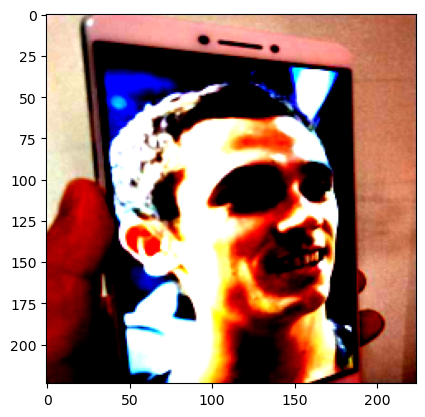

In [31]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  
  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : live")
  else:
    print("Prediction : spoof")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

In [32]:
model.eval()  # Set the model to evaluation mode

total_loss = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float().to(device)  # Reshape target to match model output

        yhat = model(x_batch)  # Perform forward pass
        loss = loss_fn(yhat, y_batch)  # Calculate loss

        total_loss += loss.item() * x_batch.size(0)  # Accumulate loss

        total_correct += ((yhat.sigmoid() > 0.5) ==  (y_batch > 0.5)).sum().item()  # Count correct predictions
        total_samples += x_batch.size(0)  # Count total samples

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print('Evaluation loss: {:.4f}, Accuracy: {:.4f}'.format(avg_loss, accuracy))

Evaluation loss: 0.2069, Accuracy: 0.9276


In [37]:
torch.save(model, os.path.join(git_dir, 'models/resnet50.pt'))

In [35]:
model_path = os.path.join(git_dir, 'models/resnet50.pt')
loaded_model = torch.load(model_path)

In [36]:
loaded_model.eval()  # Set the loaded_model to evaluation mode

total_loss = 0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float().to(device)  # Reshape target to match loaded_model output

        yhat = loaded_model(x_batch)  # Perform forward pass
        loss = loss_fn(yhat, y_batch)  # Calculate loss

        total_loss += loss.item() * x_batch.size(0)  # Accumulate loss

        total_correct += ((yhat.sigmoid() > 0.5) ==  (y_batch > 0.5)).sum().item()  # Count correct predictions
        total_samples += x_batch.size(0)  # Count total samples

avg_loss = total_loss / total_samples
accuracy = total_correct / total_samples

print('Evaluation loss: {:.4f}, Accuracy: {:.4f}'.format(avg_loss, accuracy))

Evaluation loss: 0.2069, Accuracy: 0.9276
